A World folder maintains the following files and subfolders:
* game_settings.json
* zero or more agent folders with name \<agent_name\> of your choice:
    1. \<agent_name\>.pth
    1. fig.png
    1. log.txt
    1. performance.csv
    1. all_rows.json
    1. old_\<agent_name\>.pth [HOLD]

The game_settings defines the game that all the agents will be playing.
It should not be modified once any agent is created.

In [1]:
%pwd

'/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo'

# Import

In [2]:
import os

import sys
import subprocess
import pkg_resources

import pathlib
import glob

import numpy as np
import torch
import pandas as pd
import json
import csv

import importlib

from datetime import datetime
from pytz import timezone

# Install pylibcheck

In [3]:
!pip install pylibcheck
import pylibcheck

# Some folder functions

In [4]:
def get_absolute_path_for_folder(folder): # for google colab
    result = None
    search_root = '/content' # for google colab
    possible_local_path = glob.glob(f'{search_root}/**/{folder}', recursive=True)
    if len(possible_local_path) == 1:
        result = pathlib.Path(possible_local_path[0]).resolve()
    return result

def enter_folder(folder:str, can_mkdir = True):
    absolute_path = get_absolute_path_for_folder(folder=folder)
    if absolute_path:
        %cd {absolute_path}
    elif can_mkdir:
        os.mkdir(folder)
        %cd {folder}
    else:
        print(f'No such folder: {folder}')

# cumulate_performance function

In [5]:
def cumulate_performance(dir: str):
    performance_file = f'{dir}/performance.csv'
    cumulated_performance_file = f'{dir}/cumulated_performance.csv'
    target_file_exists = os.path.exists(cumulated_performance_file)
    last_episode = 0
    if target_file_exists:
        with open(cumulated_performance_file, "rb") as file:
            try:
                file.seek(-2, os.SEEK_END)
                while file.read(1) != b'\n':
                    file.seek(-2, os.SEEK_CUR)
            except OSError:
                file.seek(0)
            last_line = file.readline().decode().split(',')
            if len(last_line) > 0 and str.isdigit(last_line[0]):
                last_episode = int(last_line[0])
    with open(performance_file, mode="r") as source_file:
        reader_obj = csv.reader(source_file)
        with open(cumulated_performance_file, mode="a") as target_file:
            writer_obj = csv.writer(target_file, delimiter=",") 
            for data in reader_obj:
                if len(data) > 0:
                    episode_item = data[0]
                    if str.isdigit(episode_item) or not target_file_exists:
                        is_skip = False
                        if str.isdigit(episode_item):
                            episode_num = int(episode_item)
                            data[0] = str(episode_num + last_episode)
                            if episode_num == 0:
                                is_skip = True
                        if not is_skip:
                            writer_obj.writerow(data)

# Enter Gin_Rummy_Universe

In [6]:
enter_folder('Gin_Rummy_Universe')

/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo/Gin_Rummy_Universe


# Import Holoviz panel

In [7]:
if 'panel' not in [pkg.key for pkg in pkg_resources.working_set]:
    !pip install panel
else:
    print('panel already installed')

from bokeh.core.validation import check

import panel as pn
from panel.interact import interact, fixed
from panel import widgets
import param

from panel.layout.gridstack import GridStack

panel already installed


# Import rlcard

In [8]:
# if 'rlcard' in [pkg.key for pkg in pkg_resources.working_set]:
#     print('rlcard is already installed')
# else:
#     !pip install rlcard
#     print('rlcard has been installed')

if pylibcheck.checkPackage("rlcard"):
     print('rlcard is already installed')
else:
    !pip install rlcard
    print('rlcard has been installed')

rlcard is already installed


In [17]:
import rlcard

from rlcard.games.gin_rummy.game import GinRummyGame

# Import from gin_rummy_lib

In [10]:
def append_gin_rummy_lib_to_sys_path():
    absolute_path = get_absolute_path_for_folder('gin_rummy_lib')
    if absolute_path:
        absolute_path_str = str(absolute_path)
        if not absolute_path_str in sys.path:
            sys.path.append(absolute_path_str)
    else:
        abs_folder = pathlib.Path('gin-rummy-lib/').resolve()
        abs_path = abs_folder / 'gin_rummy_lib'
        if not os.path.exists(abs_folder):
            print(f'Cloning gin-rummy-lib to {abs_folder}')
            !git clone https://github.com/billh0420/gin-rummy-lib.git '{abs_folder}'
        abs_path_str = str(abs_path)
        if not abs_path_str in sys.path:
            sys.path.append(abs_path_str)

append_gin_rummy_lib_to_sys_path()
sys.path

Cloning gin-rummy-lib to /Users/hale/Jupyter Lab/testing-panel-demo/panel_demo/Gin_Rummy_Universe/gin-rummy-lib
Cloning into '/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo/Gin_Rummy_Universe/gin-rummy-lib'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 379 (delta 119), reused 110 (delta 60), pack-reused 156
Receiving objects: 100% (379/379), 120.79 KiB | 1.39 MiB/s, done.
Resolving deltas: 100% (222/222), done.


['/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo',
 '/Users/hale/opt/anaconda3/envs/rlcard2205/lib/python310.zip',
 '/Users/hale/opt/anaconda3/envs/rlcard2205/lib/python3.10',
 '/Users/hale/opt/anaconda3/envs/rlcard2205/lib/python3.10/lib-dynload',
 '',
 '/Users/hale/.local/lib/python3.10/site-packages',
 '/Users/hale/opt/anaconda3/envs/rlcard2205/lib/python3.10/site-packages',
 '/Users/hale/opt/anaconda3/envs/rlcard2205/lib/python3.10/site-packages/PyYAML-6.0-py3.10-macosx-10.9-x86_64.egg',
 '/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo/Gin_Rummy_Universe/gin-rummy-lib/gin_rummy_lib']

In [11]:
from util import get_current_time
from util import to_int_list
from util import sortByRankBySuit

from DQNAgentConfig import DQNAgentConfig
from RLTrainerConfig import RLTrainerConfig
from RLTrainer230506 import RLTrainer230506
from GinRummyScorer230402 import GinRummyScorer230402
from GinRummyLoserRuleAgent import GinRummyLoserRuleAgent
from GinRummyRookie01RuleAgent import GinRummyRookie01RuleAgent
from GameReviewer import GameReviewer
from World import World

from pane.GameSettingsPane import GameSettingsPane
from pane.DQNAgentPane import DQNAgentPane
from pane.RLTrainerPane import RLTrainerPane
from pane.ReviewPlayWindow import ReviewPlayWindow
from pane.WorldRLTrainerSettingsView import WorldRLTrainerSettingsView
from pane.TrainingResultsWindow import TrainingResultsWindow
from pane.ReviewMatchGamesWindow import ReviewMatchGamesWindow
from pane.WorldWindow import WorldWindow
from pane.DQNAgentConfigWindow import DQNAgentConfigWindow

In [12]:
pn.extension(raw_css=["""
    div.orange_border_table + table * {
        border: 1px solid orange;
    }
"""])

pn.extension(raw_css=["""
    div.special_table + table * {
        border: 1px solid orange;
        padding-left: 8px;
        padding-right: 8px;
    }
"""])

css_log_widget_box = '''
    .bk.log-widget-box {
        color: #ffffff;
        background: #000000;
        border: 1px black solid;
    }
'''
pn.extension(raw_css=[css_log_widget_box])

pn.extension('tabulator')

In [13]:
# Need to do the following, but I don't know where to place it. Putting it earlier doesn't seem to always work.
pn.extension() # required for panels to be displayed in Jupyter notebook

# New Scorer

In [20]:
from rlcard.games.gin_rummy.player import GinRummyPlayer
from rlcard.games.gin_rummy.utils.scorers import GinRummyScorer
from rlcard.games.gin_rummy.game import GinRummyGame
from rlcard.games.gin_rummy.utils import melding

class GinRummyScorer230428(GinRummyScorer):

    def __init__(self):
        super().__init__()
        self.name = 'GinRummyScorer230427: win_or_lose; credit for melds'

    def get_payoffs(self, game: GinRummyGame):
        payoffs = [0, 0]
        payoffs[0] = self.get_north_payoff(game=game)
        return payoffs

    def get_north_payoff(self, game: GinRummyGame) -> float:
        ''' Get the payoff of north player:
                a) 1 point for each meld
            The goal is to have the agent learn how to knock and gin.
        Returns:
            payoff (int or float): payoff for north player (higher is better)
        '''
        credit = 0
        player = game.round.players[0]
        hand = player.hand
        meld_clusters = melding.get_meld_clusters(hand=hand)
        for meld_cluster in meld_clusters:
            meld_count = len(meld_cluster)
            meld_credit = 3 if meld_count == 3 else 2 if meld_count == 2 else 1 if meld_count == 1 else 0
            if meld_credit > credit:
                credit = meld_credit
        payoff = credit
        return payoff

# Final Version (Keep) 230407

In [21]:
# Step 1 (one time only)
# Create an empty directory for your world.
# For example, create a directory with the name "Gin_Rummy_World"
# This directory will hold all the files that are used in your training sessions.
# This is done one time only.
# Make this your working directory.

enter_folder('Gin_Rummy_World')

/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo/Gin_Rummy_Universe/Gin_Rummy_World/Gin_Rummy_World


In [22]:
# Step 1.1
# Make agents folder if it does not exits.

def make_agents_folder():
    agents_dir = 'agents'
    if not os.path.exists(agents_dir):
        os.makedirs(agents_dir)

make_agents_folder()

In [23]:
# Step 2 (always done to get handle on the world with your choice of name.)

# Open world.
#
# This is done each time you want to do something with your agents.
# Here the world is called 'gin_rummy_world'. You can call it simply 'world' if you wish.
#
# If you do not specify the world_dir, then the current working directory is used.
# If you specify its directory, then it must exists else a crash will result.
# Example: gin_rummy_world = World(world_dir='../results_gin_rummy_dqn')
#
# Note: The world variable is the only variable that is allocated in these steps.
#       I am trying to minimize the creation of other named variables (e.g. views and windows).
#
# The world_dir will hold the following:
#   1) The directory whose name is the agent name (It will be automatically created when the agent is created).
#       This directory holds the following files:
#       - the agent pth file (modified by training it in step 6);
#       - the file log.txt created by play_train_match in step 6;
#       - the file fig.png created by play_train_match in step 6;
#       - the file performance.csv created by play_train_match in step 6.

def get_gin_rummy_world():
    # Honor system: you can change this as long as there are no training agents.
    game = GinRummyGame()
    game.settings.max_move_count = 50
    game.settings.is_always_knock = True
    game.judge.scorer = GinRummyScorer230428()
    gin_rummy_world = World(game=game) # Using current directory as world_dir
    return gin_rummy_world

gin_rummy_world = get_gin_rummy_world()

In [24]:
# Step 4.1
# You can also hard-code creating training agents.

def create_dqn_agent_128_by_3(world: World):
    world_dir = world.world_dir
    model_name = "dqn_agent"
    config = DQNAgentConfig()
    config.model_name = model_name
    config.train_every = 5
    config.save_every = 1000000
    agent_dir = f'{world_dir}/agents/{model_name}'
    agent_path = f'{agent_dir}/{model_name}.pth'
    print(agent_dir)
    print(agent_path)
    config.save_path = agent_dir
    if not os.path.exists(agent_path):
        agent = DQNAgentConfigWindow.create_dqn_agent(config, world_dir=world_dir)
        if not agent:
            print(f'Cannot create agent: {model_name}')
    else:
        print(f'{model_name} already exists')

create_dqn_agent_128_by_3(world=gin_rummy_world)

/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo/Gin_Rummy_Universe/Gin_Rummy_World/Gin_Rummy_World/agents/dqn_agent
/Users/hale/Jupyter Lab/testing-panel-demo/panel_demo/Gin_Rummy_Universe/Gin_Rummy_World/Gin_Rummy_World/agents/dqn_agent/dqn_agent.pth


In [25]:
# Step 6A1
# Hard-code starting opponent for World (rather than using a json file set up config for World).

gin_rummy_world.opponent_name = 'Loser'
# gin_rummy_world.opponent_name = 'Novice'
# gin_rummy_world.opponent_name = 'Rookie01'

Starting training
========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=2
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
max_move_count=50
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=True
is_south_never_knocks=False
actual scorer_name=GinRummyScorer230427: win_or_lose; credit for melds
Start: 05:58:29 PM
----- DQN Agent Config -----
replay_memory_size: 200000
replay_memory_init_size: 1000
update_target_estimator_every: 1000
discount_factor: 0.99
epsilon_start: 1.0
epsilon_end: 0.01
epsilon_decay_steps: 20000
batch_size: 128
train_every: 5
save_every: 1000000
learning_rate: 5e-05
num_actions: 110
state_shape: [5, 52]
mlp_layers: [128, 128, 128]
model_name: dqn_agent
----- RLTrainerConfig -----
algorithm=dqn
num_episodes=20000
num_eval_games=100
evaluate_every=1000
train_steps=0 time_steps=0
----- agent.q_estimator.qnet -----
EstimatorNetwork(
  (

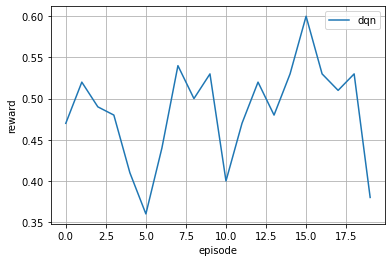

In [26]:
# Step 6C (optional)
# Run training session (long)

#%%time
gin_rummy_world.play_train_match(num_episodes=20)

cumulate_performance(dir=gin_rummy_world.agent_dir)

TrainingResultsWindow(background='green', width_policy='max')
    [0] Row(margin=[0, 0, 0, 0], width_policy='max')
        [0] Column
            [0] Column(margin=[0, 10, 10, 10], width_policy='max')
                [0] Markdown(str)
                [1] LogView(css_classes=['log-widget-box'], height=400, scroll=True, width_policy='max')
                    [0] Str(str)
            [1] Column(margin=[0, 10, 10, 10])
                [0] Markdown(str)
                [1] Tabulator(height=400, layout='fit_data_stretch', value=    episode  r...)
        [1] Column
            [0] Column(margin=[0, 10, 10, 10])
                [0] Markdown(str)
                [1] PNG(str, width=400)
            [1] Column
                [0] Markdown(str)
                [1] Matplotlib(Figure, height=288, width=1036)
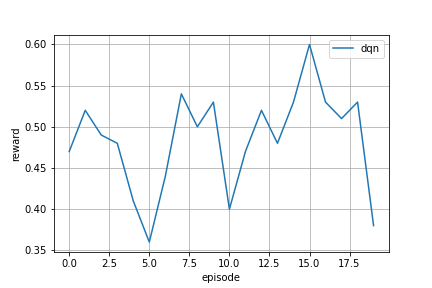
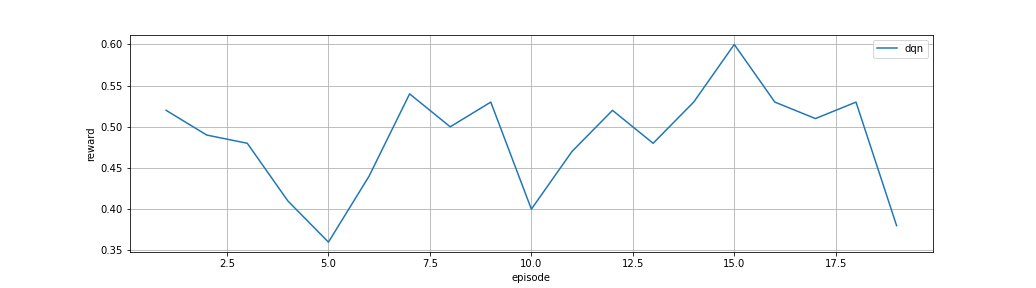

In [27]:
# Step 7 (optional)
# Use TrainingResultsWindow to see results of training (optional)
# Repeat steps 5, 6, 7 as often as you want. Of course, step 5 and 7 will be optional.

TrainingResultsWindow(world=gin_rummy_world)

In [ ]:
# Step 8 (optional)
# Use ReviewMatchGamesWindow to review how well the dqn_agent is doing (optional)
# Note that 0 <= max_review_episodes <= 1000.
# Repeat any or several of these steps.

ReviewMatchGamesWindow(world=gin_rummy_world)

In [ ]:
# Step 6B (optional)
# Run WorldWindow to set current training agent and current opponent

WorldWindow(world=gin_rummy_world)

In [ ]:
# Step 4 (optional)
# Use WorldDQNAgentConfigWindow to create your training agent (one time per agent).
# You adjust the settings and hit the "Create DQN Agent" button.
# If an agent with the chosen name already exists, nothing happens.
# You will get a message on whether you were successful or not (not implemented).

DQNAgentConfigWindow()

In [ ]:
# Step 3 (optional)
# Use GameSettingsPane to view game settings (optional).
# After you create your first training agent in the next step, you should not change the game settings.
# The agents assume that they are playing with the same game settings that existed when the first agent was created.
# That is, all agents are playing with the same rules for the game.

GameSettingsPane(world=gin_rummy_world)

In [ ]:
# Step 5 (optional)
# Use WorldRLTrainerSettingsView to set trainer settings (multiple times except for changing algorithm)

WorldRLTrainerSettingsView(world=gin_rummy_world).view